In [1]:
import os
from pandas import read_csv
import torch
import torchvision as tv
import torchvision.transforms.v2 as v2
from torch.utils.data import Dataset, DataLoader, random_split
from icecream import ic
from PIL import Image
import matplotlib.pyplot as plt
import random
import numpy as np
from dataLoading import CIFAR10Dataset
from utils import showTransform, displayImageGrid



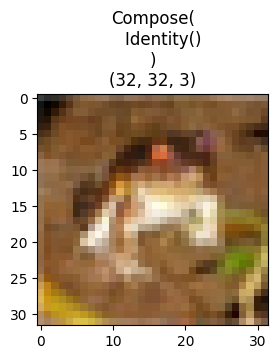

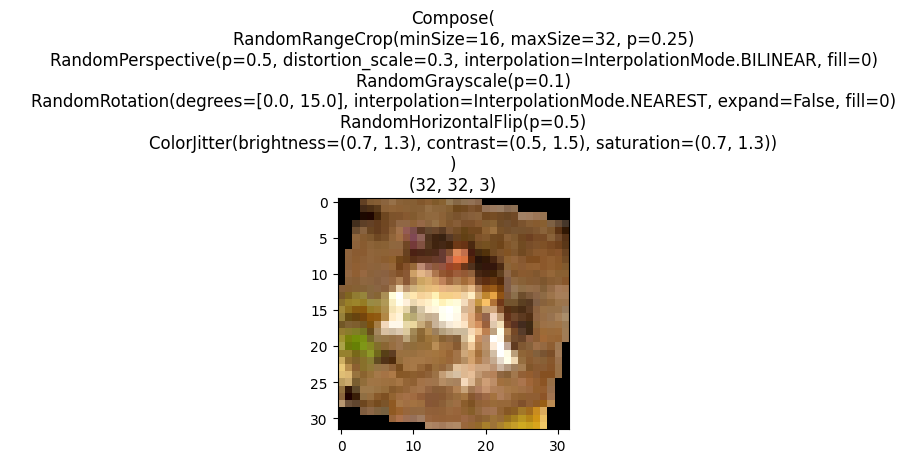

In [28]:
# Look here for more visuals on v2 transforms
# https://pytorch.org/vision/stable/auto_examples/transforms/plot_transforms_illustrations.html#geometric-transforms

transform1 = v2.Compose([
    v2.Resize(size=(32, 32), antialias=True)
])

autoAugmentCIFAR = v2.Compose([
    v2.AutoAugment(v2.AutoAugmentPolicy.CIFAR10),
    
    # Ensure everything is in the right size and format before ending our transforms
    v2.Resize(size=(32, 32), antialias=True),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
])



class RandomRangeCrop(v2.Transform):
    
    
    def __init__(self, minSize=16, maxSize=32, p=0.25):
        
        super().__init__()
        
        self.minSize = minSize
        self.maxSize = maxSize
        
        assert 0 < p < 1, f'Invalid value of p: {p}'
        self.p = p
        
        pass
    
    def forward(self, img):
        
        if np.random.rand() < self.p:
            randomDims = np.random.randint(self.minSize, self.maxSize+1)
            cropped = v2.RandomCrop(size=randomDims)(img)
            return v2.Resize(size=(32, 32), antialias=True)(cropped)
        else:
            return img
        



randomGray = v2.RandomApply(
    transforms=[v2.Compose([
        v2.Grayscale(1)
    ])]
)

# TODO: Add color jitter, randon horizontal flip
customTransforms = v2.Compose([
    RandomRangeCrop(),
    v2.RandomPerspective(distortion_scale=0.3, p=0.5),
    v2.RandomGrayscale(),
    v2.RandomRotation(degrees=(0, 15)),
    v2.RandomHorizontalFlip(p=0.5),
    v2.ColorJitter(brightness=0.3, contrast=0.5, saturation=0.3),
])

showTransform('sampleImg.png', transform=None)
# showTransform('sampleImg.png', transform=transform1)
# showTransform('sampleImg.png', transform=transform2)
showTransform('sampleImg.png', transform=customTransforms)


In [7]:
# Define transformations for data augmentation
transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
])

transform = autoAugmentCIFAR

# Create dataset instances
fullDataset = CIFAR10Dataset(rootDirectory='cifar-10', csvFilename='trainLabels.csv', dataFolder='train', transform=transform)

generator = torch.Generator().manual_seed(42)
TRAIN_DATASET, VALIDATION_DATSET, TEST_DATSAET = random_split(fullDataset, [0.8, 0.1, 0.1], generator=generator)

# Create DataLoader instances
BATCH_SIZE = 256
trainLoader = DataLoader(TRAIN_DATASET, batch_size=BATCH_SIZE, shuffle=False)



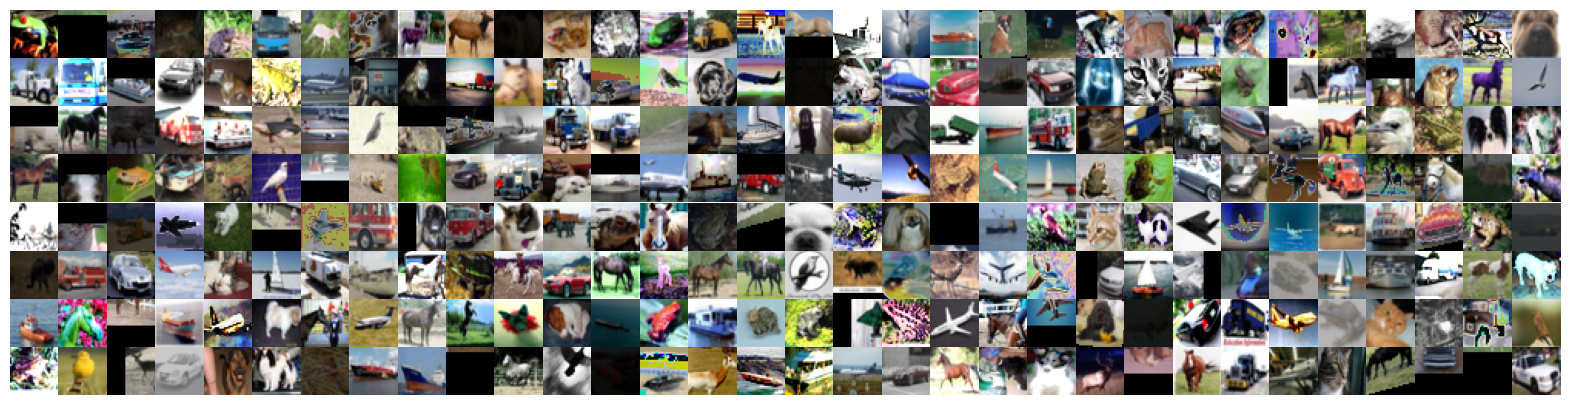

ic| features.size(): torch.Size([256, 3, 32, 32])
ic| labels.size(): torch.Size([256])


frog	bird	ship	frog	frog	truck	deer	dog	deer	deer	dog	dog	frog	frog	truck	horse	horse	ship	airplane	ship	dog	bird	cat	cat	horse	frog	deer	deer	cat	bird	deer	dog	
6	2	8	6	6	9	4	5	4	4	5	5	6	6	9	7	7	8	0	8	5	2	3	3	7	6	4	4	3	2	4	5	

torch.Size([256])

In [8]:
features, labels = next(iter(trainLoader))

trainFeaturesArray = features.numpy().transpose(2, 3, 1, 0)
trainLabelsArray = labels.numpy()

displayImageGrid([trainFeaturesArray[..., idx] for idx in range(BATCH_SIZE)], H=8, W=32, figsize=(20, 5))

[print(fullDataset.numberStringMappings[val], end='\t') for val in trainLabelsArray[:32]]
print()
[print(val, end='\t') for val in trainLabelsArray[:32]]

ic(features.size())
ic(labels.size())

In [ ]:
# Define transformations for data augmentation
transform = v2.Compose([
    # Pytorch says the below transform will be depricated, so use these instead
    # v2.ToTensor(),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    # Add other transforms here
])

# Create dataset instances
fullDataset = CIFAR10Dataset(rootDirectory='cifar-10', csvFilename='trainLabels.csv', dataFolder='train', transform=transform)
TRAIN_DATASET, VALIDATION_DATSET, TEST_DATSAET = random_split(fullDataset, [0.8, 0.1, 0.1])

BATCH_SIZE = 256
trainLoader = DataLoader(TRAIN_DATASET, batch_size=BATCH_SIZE, shuffle=False)

mean = 0.
std = 0.
for images, _ in trainLoader:
    
    batchSamples = images.size(0)
    # Get an image view of shape (batchSamples, C, H*W) which is faster than a transpose as we don't shift any data
    images = images.view(batchSamples, images.size(1), -1)
    # Calculate total mean and total std over dim=2
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)

# Divide means and stdevs by number of samples
mean /= len(trainLoader.dataset)
std /= len(trainLoader.dataset)
print(mean)
print(std)


In [ ]:
# Update transform with normalized values
transform = v2.Compose([
    # Pytorch says the below transform will be depricated, so use these instead
    # v2.ToTensor(),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    # Add other transforms here
    v2.Normalize(mean=mean, std=std)
])

# Create dataset instances
fullDataset = CIFAR10Dataset(rootDirectory='cifar-10', csvFilename='trainLabels.csv', dataFolder='train', transform=transform)
TRAIN_DATASET, VALIDATION_DATSET, TEST_DATSAET = random_split(fullDataset, [0.8, 0.1, 0.1])

BATCH_SIZE = 256
trainLoader = DataLoader(TRAIN_DATASET, batch_size=BATCH_SIZE, shuffle=False)